# Setup

In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import FastMarkerCluster
sns.set(style="darkgrid")

In [2]:
raw_df = pd.read_csv('listings.csv')

# Data preprocessing

In [3]:
## Remove unwanted columns
drop = ["name", "last_review", "reviews_per_month", "id", "host_id", "host_name", "calculated_host_listings_count", "availability_365"]
raw_df.drop(drop, inplace=True, axis=1)
## Remove price outliers
q1 = raw_df[['price']].quantile(0.25)
q3 = raw_df[['price']].quantile(0.75)
IQR = q3 - q1
df = raw_df[~((raw_df < (q1 - 1.5 * IQR)) |(raw_df > (q3 + 1.5 * IQR))).any(axis=1)]
## Remove minimum nights > 365
df = df.drop(df[df.minimum_nights > 365].index)
## Assign risky column
q90 = float(df[['number_of_reviews']].quantile(0.9))
df['risk_rating'] = np.where((df['minimum_nights'] < 90) & (df['number_of_reviews'] < q90),
  'High risk', np.where((df['minimum_nights'] < 90) & (df['number_of_reviews'] >= q90),
                        "Medium risk", "Low risk"))
## Assign minimum nights >= 90 column
df['min_night_90_days'] = np.where(df['minimum_nights'] >= 90, '90 nights and above', 'Below 90 nights')


In [4]:
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,risk_rating,min_night_90_days
0,North Region,Woodlands,1.44255,103.79580,Private room,83,180,1,Low risk,90 nights and above
1,Central Region,Bukit Timah,1.33235,103.78521,Private room,81,90,18,Low risk,90 nights and above
2,North Region,Woodlands,1.44246,103.79667,Private room,69,6,20,High risk,Below 90 nights
3,East Region,Tampines,1.34541,103.95712,Private room,206,1,14,High risk,Below 90 nights
4,East Region,Tampines,1.34567,103.95963,Private room,94,1,22,High risk,Below 90 nights


# Exploratory Data Analysis

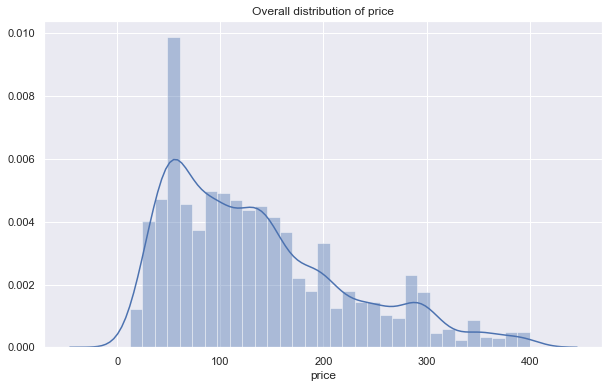

In [5]:
## Price distribution
plt.figure(figsize = (10,6))
sns.distplot(df["price"])
plt.title("Overall distribution of price")
plt.show()

In [6]:
## Check differences in distribution using Kruskal-Wallis Non-parametric Multi-Independent Samples
stats.kruskal(*[group["price"].values for name, group in df.groupby("neighbourhood_group")])


KruskalResult(statistic=472.38454622337827, pvalue=6.282024944436425e-101)

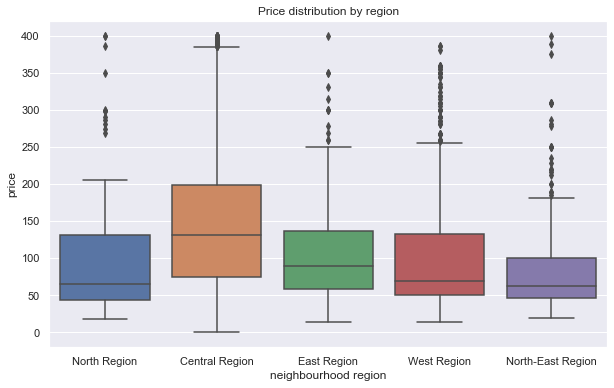

In [7]:
## Distribution of price over regions
plt.figure(figsize=(10,6))
sns.boxplot(y="price",x ='neighbourhood_group' ,data = df)
plt.title("Price distribution by region")
plt.xlabel("neighbourhood region")
plt.show()

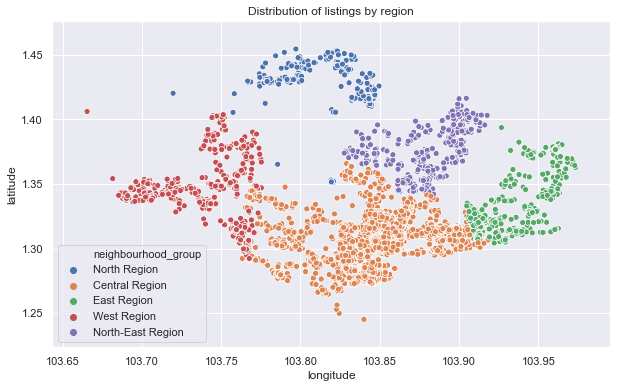

In [8]:
## Finding the distribution of listings by region
plt.figure(figsize = (10,6))
sns.scatterplot("longitude","latitude",hue = "neighbourhood_group", data = df)
plt.title("Distribution of listings by region")
plt.show()

In [9]:
## Listing distribution through folium
m = folium.Map([1.38255,103.83580],zoom_start=11)
m.add_child(FastMarkerCluster(df[['latitude','longitude']].values.tolist()))
display(m)

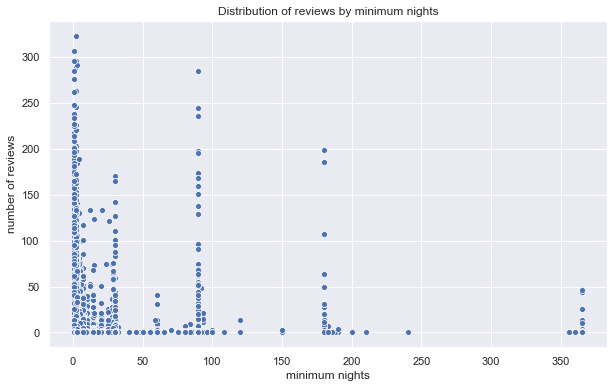

In [10]:
plt.figure(figsize = (10,6))
sns.scatterplot(x = 'minimum_nights',y = 'number_of_reviews',data = df)
plt.title("Distribution of reviews by minimum nights")
plt.xlabel('minimum nights')
plt.ylabel('number of reviews')
plt.show()

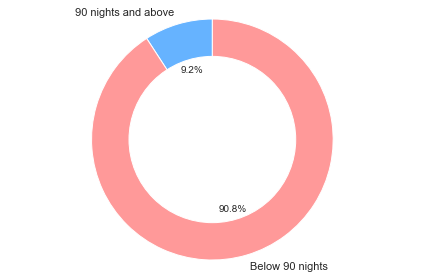

In [11]:
## Pie chart for listings above 90 nights
labels = list(df['min_night_90_days'].unique())
sizes = list(df.groupby('min_night_90_days').count()['neighbourhood'])
sizes.sort()
#colors
colors = ['#66b3ff','#ff9999'] 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.69,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

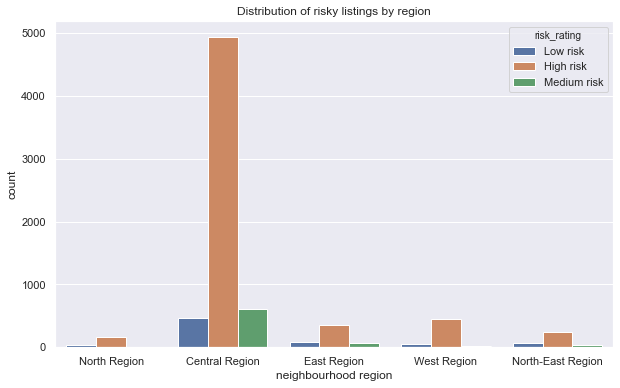

In [16]:
## Listing barplot distribution by region
plt.figure(figsize=(10,6))
sns.countplot(x = 'neighbourhood_group',hue = "risk_rating",data = df)
plt.title("Distribution of risky listings by region")
plt.xlabel('neighbourhood region')
plt.show()

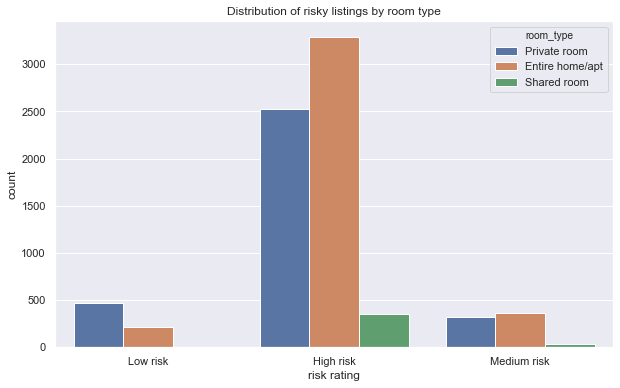

In [17]:
## Listing barplot distribution by room type
plt.figure(figsize=(10,6))
sns.countplot(x = 'risk_rating',hue = "room_type",data = df)
plt.title("Distribution of risky listings by room type")
plt.xlabel('risk rating')
plt.show()

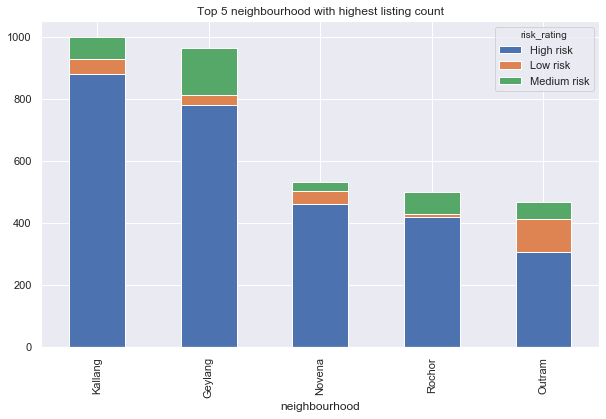

In [15]:
## Top 5 neighbourhoods with most listings
df_plot = df.groupby(['neighbourhood', 'risk_rating']).size().reset_index().pivot(columns='risk_rating',index = 'neighbourhood', values=0)
df_plot['Total'] = df_plot.sum(axis = 1)
df_plot = df_plot.sort_values(by = ['Total'], ascending = False).head(5)
df_plot.drop(['Total'], inplace=True, axis=1)
df_plot.plot(kind = 'bar', stacked = True, figsize=(10,6), title = 'Top 5 neighbourhood with highest listing count')
plt.show()